In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# data directory
data_dir = Path("../data")

input_dir = data_dir / "input"
raw_dir = data_dir / "raw"
output_dir = data_dir / "processed"
sample_dir = data_dir / "samples"

rss_dir = raw_dir / "rss"
twitter_dir = raw_dir / "twitter"

## Load articles

In [20]:
articles = pd.read_csv(
    output_dir / "articles.csv",
    index_col="url_id",
)

In [21]:
orig_counts = articles.groupby("source").size()

## Postprocessing of collected articles

Articles are excluded if:

- they were not successfully parsed by `newspaper`
- they have been published before Mar 1 or after Apr 30 
- they are in Spanish
- they have been used in previous samples

### Successful content parsing

Remove articles that were not properly parsed by `newspaper`

In [22]:
# set success to False for all articles with parse_errors
articles.loc[(articles == "parse_error").any(axis=1), "success"] = False

In [23]:
df = articles[~articles.success]
errors = {
    "404 Client Error": df.error_msg.str.contains("404 Client Error").sum(),
    "402 Client Error": df.error_msg.str.contains("402 Client Error").sum(),
    "Timeout": df.error_msg.str.contains("Read timed out").sum(),
    "Wrong domain": df.error_msg.str.contains("wrong domain").sum(),
    "Parse error": (articles == "parse_error").any(axis=1).sum()
}

print(f"Removing {(~articles.success).sum()} that were not parsed successfully.")
print(f"Breakdown of reasons: {errors}")

articles[~articles.success].source.value_counts()

Removing 39 that were not parsed successfully.
Breakdown of reasons: {'404 Client Error': 27, '402 Client Error': 1, 'Timeout': 0, 'Wrong domain': 11, 'Parse error': 6}


newsmed    20
ifls       14
popsci      4
wired       1
Name: source, dtype: int64

In [24]:
articles = articles[articles.success]

### Publication date

Only keep articles published Mar 1 - Apr 30

In [25]:
# Convert dates to datetime format
articles.published = pd.to_datetime(articles.published, utc=True)
articles.modified = pd.to_datetime(articles.modified, utc=True)

In [26]:
good_articles = (articles.published>="2021-03-01")&(articles.published<="2021-04-29")
bad_articles = ~good_articles
print(f"Removing {bad_articles.sum()} articles in Spanish")

articles[bad_articles]["source"].value_counts()

Removing 1645 articles in Spanish


popsci       1420
newsmed        82
ifls           73
healthday      29
medpage        21
guardian       10
nyt             8
wired           2
Name: source, dtype: int64

In [27]:
articles = articles[good_articles]

### Language

Remove articles that aren't English

In [28]:
spanish_articles = articles.section.isin(["Consumer News in Spanish", "en Español", "HealthDay TV en Español"])
print(f"Removing {spanish_articles.sum()} articles in Spanish")

articles[spanish_articles]["source"].value_counts()

Removing 228 articles in Spanish


healthday    219
nyt            9
Name: source, dtype: int64

In [29]:
articles = articles[~spanish_articles]

### Intercoding samples

Remove articles that were used for previous samples except `all_venues_sample_05052021.csv` (this file is already part of the final dataset and has been coded).

In [30]:
samples = list(sample_dir.glob("*.csv"))

sampled_urls = []
for sample in samples:
    if sample.name == "all_venues_sample_05052021.csv":
        continue
    df = pd.read_csv(sample)
    if "link" in df:
        sampled_urls.extend(df["link"].tolist())
    else:
        sampled_urls.extend(df["url"].tolist())
        
sampled_articles = articles.url.isin(sampled_urls)
print(f"Removing {sampled_articles.sum()} articles previously sampled")
articles[sampled_articles]["source"].value_counts()

Removing 41 articles previously sampled


wired        10
nyt           8
healthday     7
medpage       7
guardian      7
newsmed       2
Name: source, dtype: int64

In [31]:
articles = articles[~sampled_articles]

## Final dataset

In [32]:
articles.shape

(5172, 12)

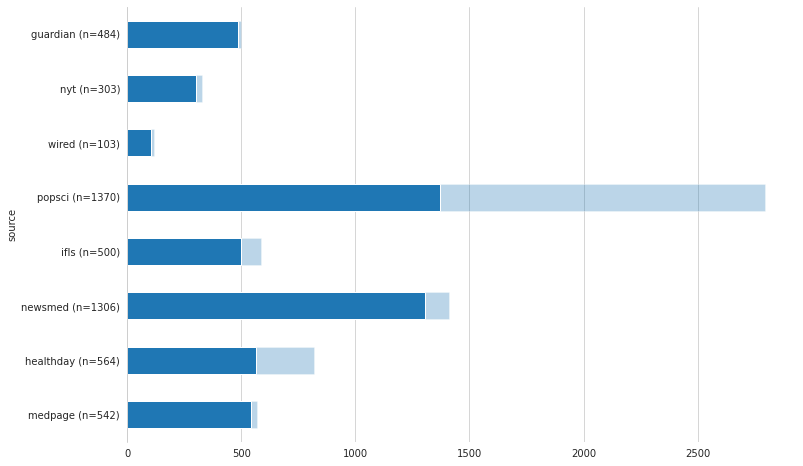

In [33]:
source_order = ["guardian", "nyt", "wired", "popsci", "ifls", "newsmed", "healthday", "medpage"]
source_order = source_order[::-1]

plt.figure(figsize=(12,8))
with sns.axes_style("whitegrid"):
    ax = orig_counts.loc[source_order].plot(kind="barh", alpha=.3)
    pdf = articles.groupby("source").size()
    pdf.loc[source_order].plot(kind="barh", ax=ax)
    sns.despine(bottom=True)
    plt.grid(False, axis="y")
#     xticks = range(100, 1600, 100)
    yticks, labels = plt.yticks()
    labels = [f"{_.get_text()} (n={pdf[_.get_text()]})" for _ in labels]
    plt.yticks(ticks=yticks, labels=labels)
#     plt.xticks(xticks, xticks)

In [34]:
articles.to_csv(output_dir / "filtered_articles.csv")